In [99]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import common

In [100]:
root_dir = Path("../data_out_02092024/langmuir/finn_all_UQ_factors")

In [101]:
records = []

for loss_path in root_dir.rglob("loss.txt"):
    finn_dir = loss_path.parent
    isotherm = "langmuir" if "langmuir" in str(finn_dir) else "freundlich"
    
    try:
        c_train = np.load(finn_dir / "c_train.npy")
        c_train_pred = np.load(finn_dir / "c_train_predictions.npy")
        c_full = np.load(finn_dir / "c_full.npy")
        c_full_pred = np.load(finn_dir / "c_full_predictions.npy")
        mse_c_train = np.square(c_train - c_train_pred).mean()
        mse_c_full = np.square(c_full - c_full_pred).mean()
    except FileNotFoundError:
        mse_c_train = np.nan
        mse_c_full = np.nan

    records.append({
        "finn_dir": finn_dir,
        "isotherm": isotherm,
        "finn_dir_label": finn_dir.name.split("_")[0],
        "epochs": len(np.loadtxt(finn_dir / "loss.txt")),
        "MSE(c_train, c_train_pred)": mse_c_train,
        "MSE(c_full, c_full_pred)": mse_c_full,
    })

finn_dir_df = pd.DataFrame.from_records(records)
display(len(finn_dir_df))
display(finn_dir_df.dtypes)
display(finn_dir_df.head())

16

finn_dir                       object
isotherm                       object
finn_dir_label                 object
epochs                          int64
MSE(c_train, c_train_pred)    float64
MSE(c_full, c_full_pred)      float64
dtype: object

,finn_dir,isotherm,finn_dir_label,epochs,"MSE(c_train, c_train_pred)","MSE(c_full, c_full_pred)"
0,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,673912496,100,0.000011,0.000018
1,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,695869966,100,0.000011,0.000017
2,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,110173383,100,0.000006,0.000012
3,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,761087777,100,0.000004,0.000007
4,../data_out_02092024/langmuir/finn_all_UQ_fact...,langmuir,253365502,100,0.000009,0.000013


In [102]:
# def has_finn_converged(finn_dir_df_row):
#     row = finn_dir_df_row
#     has_converged = True
#     if 

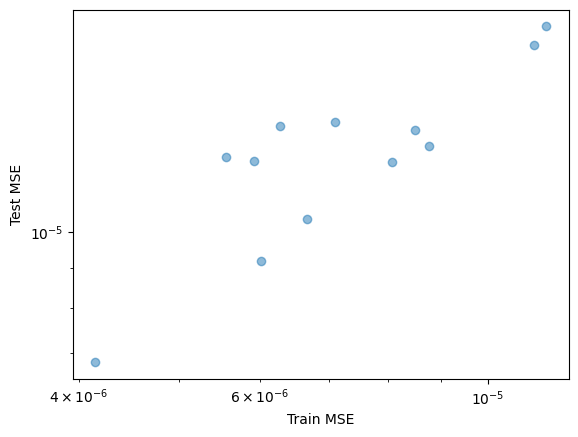

In [110]:
# tmp_mask = (finn_dir_df["MSE(c_train, c_train_pred)"] < 1e-4) & (finn_dir_df["MSE(c_train, c_train_pred)"] > 5e-6)
tmp_mask = np.ones(len(finn_dir_df), dtype=bool)
plt.scatter(finn_dir_df["MSE(c_train, c_train_pred)"][tmp_mask], finn_dir_df["MSE(c_full, c_full_pred)"][tmp_mask], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train MSE")
plt.ylabel("Test MSE")
plt.show()

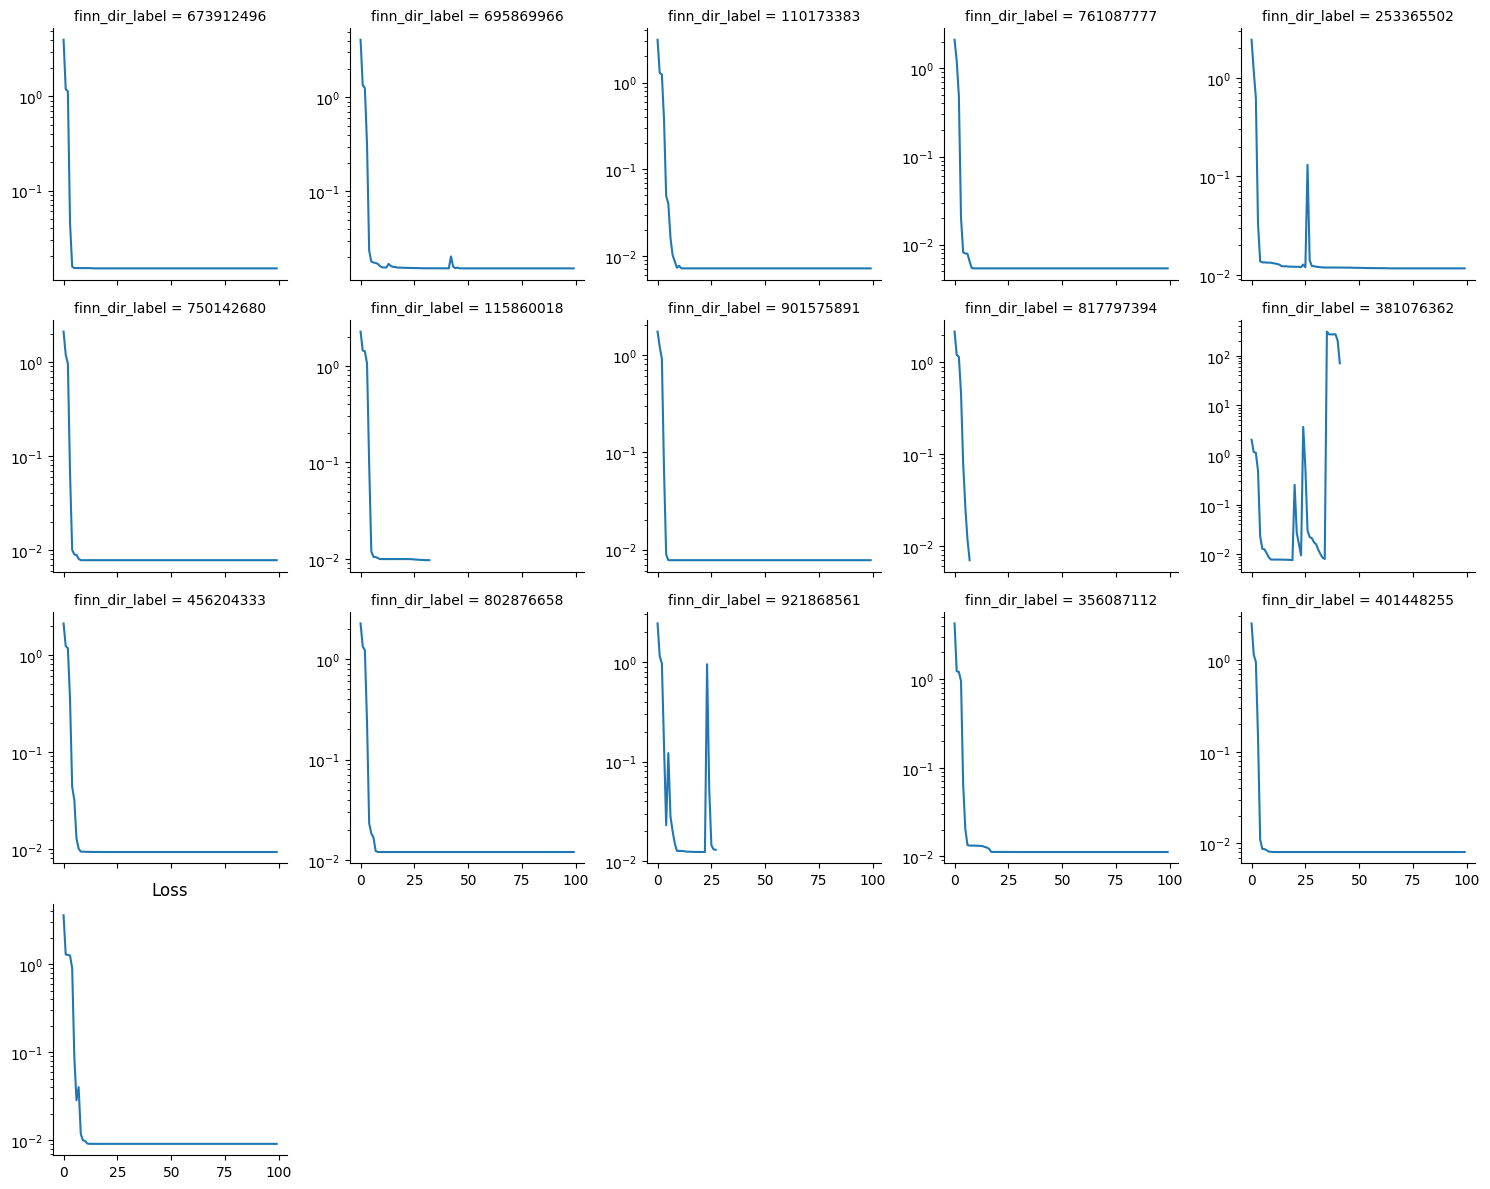

In [104]:
def load_and_plot(data, *args, **kwargs):
    y = np.loadtxt(data["finn_dir"].iloc[0] / "loss.txt")
    plt.semilogy(y, *args, **kwargs)

g = sns.FacetGrid(
    data=finn_dir_df,
    col="finn_dir_label",
    col_wrap=5,
    sharey=False,
)

g.map_dataframe(load_and_plot)
plt.title("Loss")
plt.show()

In [105]:
def load_analytic_retardation(finn_dir_df_row):
    return np.load(
        finn_dir_df_row["finn_dir"] / f"retardation_{finn_dir_df_row['isotherm']}.npy"
    )

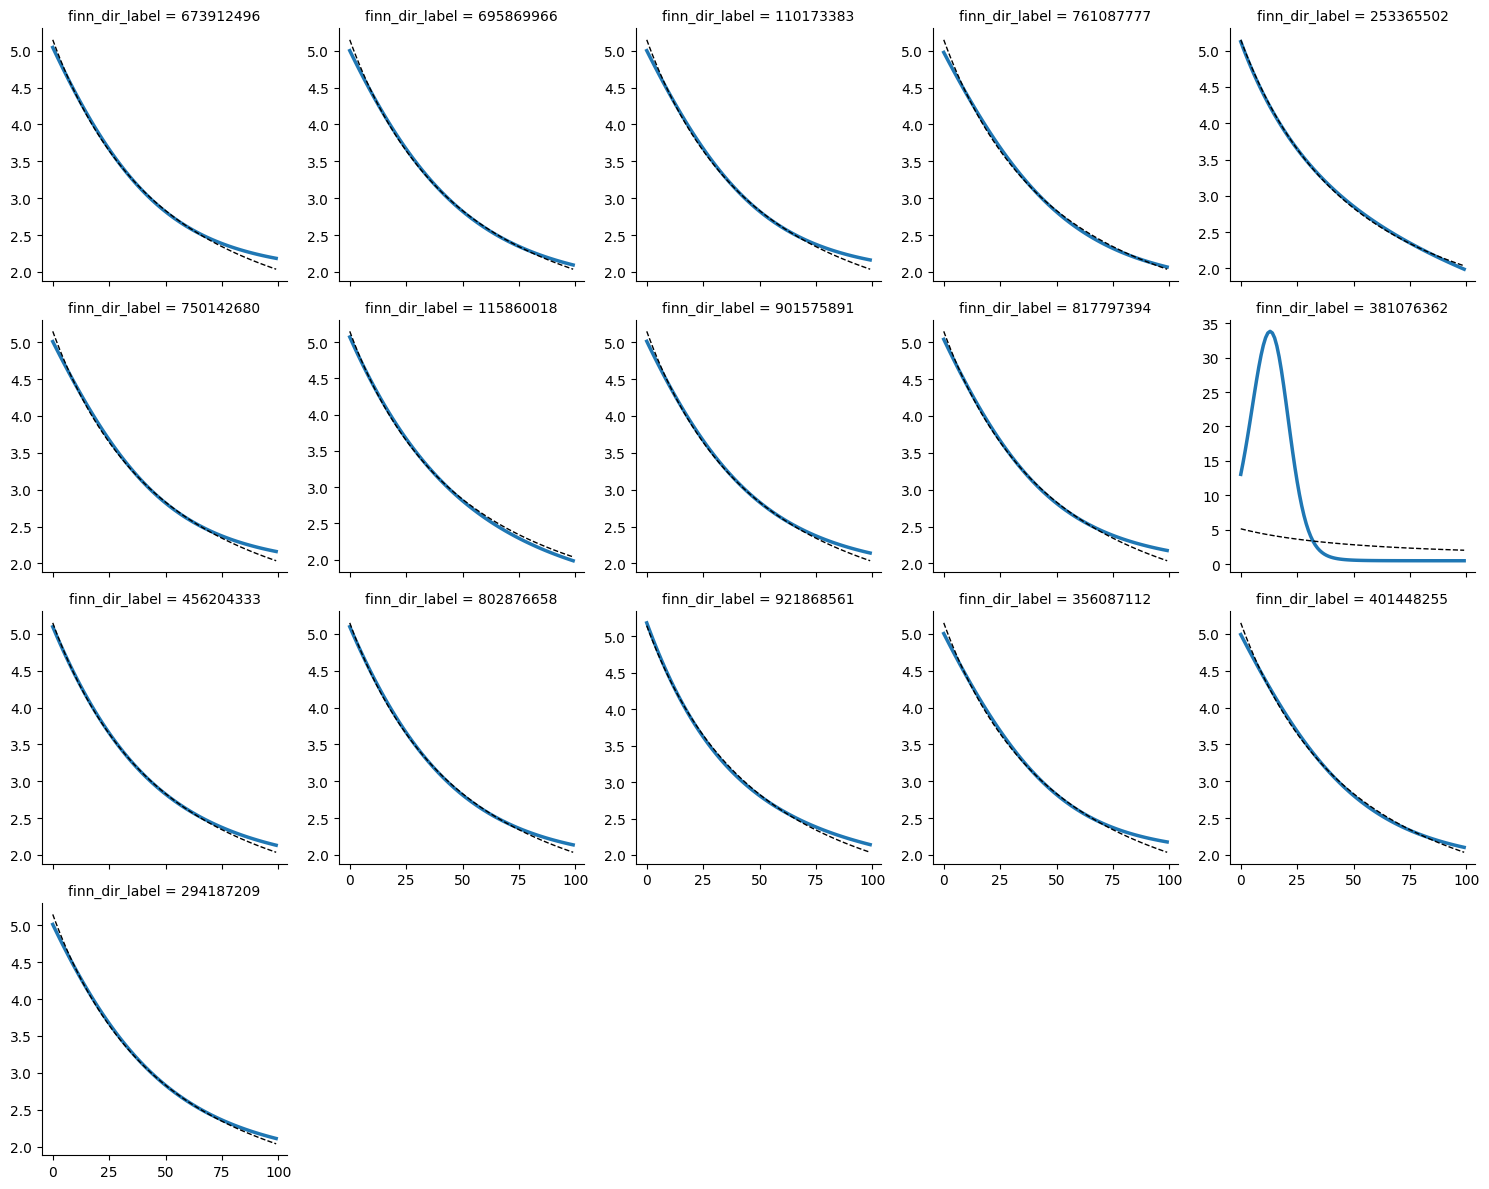

In [106]:
def final_retardation(finn_dir: Path):
    all_rets = sorted([p for p in (finn_dir / "predicted_retardations").iterdir()], key=lambda x: int(x.stem.split("_")[-1]))
    if not all_rets:
        return None
    return all_rets[-1]

def load_and_plot(data, *args, **kwargs):
    assert len(data) == 1
    y = np.load(final_retardation(data["finn_dir"].iloc[0]))
    isotherm = data["isotherm"].iloc[0]
    plt.plot(y, *args, lw=2.5, **kwargs)
    y_min, y_max = plt.ylim()  # get limits before plotting the analytical retardation
    plt.plot(load_analytic_retardation(data.iloc[0]), "k--", lw=1.0, label=isotherm.capitalize())
    if isotherm == "freundlich":
        plt.ylim(min(3, y_min), max(5, y_max))

g = sns.FacetGrid(
    data=finn_dir_df,
    col="finn_dir_label",
    col_wrap=5,
    hue="isotherm",
    sharey=False
)

g.map_dataframe(load_and_plot)
plt.show()

In [113]:
print(len(finn_dir_df))
finn_dir_df = finn_dir_df[finn_dir_df["MSE(c_full, c_full_pred)"] < 1e-4]
print(len(finn_dir_df))

16
12


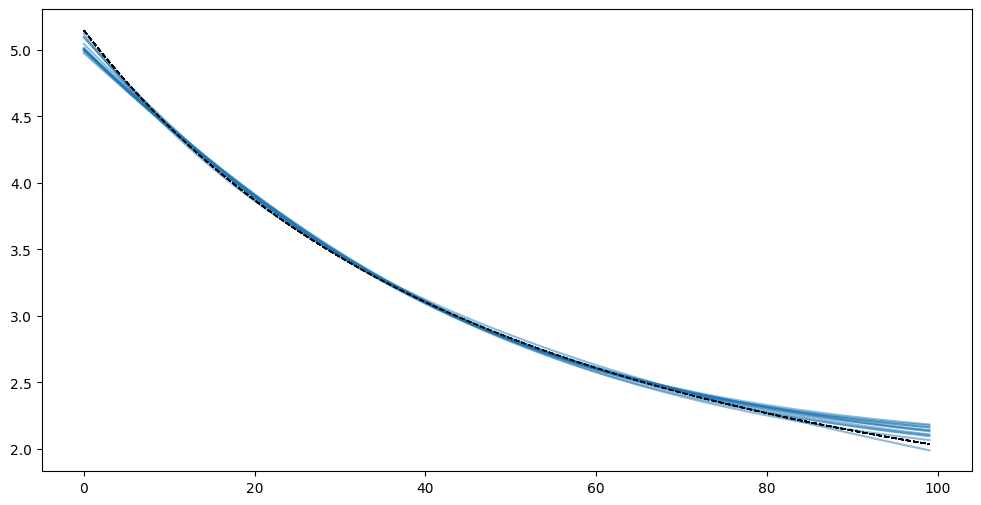

In [138]:
plt.figure(figsize=(12, 6))
for _, row in finn_dir_df.iterrows():
    ret = np.load(final_retardation(row["finn_dir"]))
    isotherm = row["isotherm"]
    plt.plot(ret, color="tab:blue", alpha=0.5)
    y_min, y_max = plt.ylim()  # get limits before plotting the analytical retardation
    plt.plot(load_analytic_retardation(row), "k--", lw=1.0, label=isotherm.capitalize())
    if isotherm == "freundlich":
        plt.ylim(min(3, y_min), max(5, y_max))